In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib
import seaborn as sns
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### A random walk with drift

The model is:

$$
y_0 = \beta_0 \ \ \text{ and } \ \ y_{t+1} = y_{t} + \beta_1 + \epsilon_t
$$


where $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.

This is similar to the linear model, but the data generating process is different.  The MLE estimates of the parameters are

$$
\begin{align*}
\hat{\beta}_1 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1}) = \frac{1}{n} (y_n - y_0)\\
\hat{\beta}_0 &= y_0\\
\hat{\sigma}^2 &= \frac{1}{n}\sum_{i=1}^n (y_i - y_{i-1} - \hat{\beta}_1)^2
\end{align*}
$$

### Drift forecast

This leads to a **drift forecast** where we predict $y_t = y_n + \beta_1 (t-n)$ for $t > n$.

In [324]:
df = pd.read_csv("data_new.csv")

In [326]:
df = df.drop(labels="Unnamed: 0", axis=1)

In [328]:
df = df[['Age (Kyr ago)', 'CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic', 'BIT index ']]

In [330]:
df.head()

,Age (Kyr ago),CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index
0,-0.04,350.85,23.43,-9.50,-35.79,3.23,0.51
1,0.08,286.50,23.38,-9.33,-35.79,3.23,0.65
2,0.14,284.01,22.91,-9.35,-35.79,3.23,0.48
3,0.31,276.72,23.31,-9.52,-35.79,3.23,0.61
4,0.41,283.73,23.80,-9.12,-35.79,3.23,0.59


In [332]:
df_reverse = df[df.columns[1:]][::-1]

In [334]:
df_reverse

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index
372,241.89,22.38,-9.20,-41.10,3.95,0.87
371,240.40,22.77,-9.25,-39.55,3.99,0.91
370,233.24,23.30,-9.33,-38.15,4.01,0.93
369,231.60,23.28,-9.02,-37.39,4.02,0.99
368,232.26,23.65,-8.71,-36.52,4.05,0.99
...,...,...,...,...,...,...
4,283.73,23.80,-9.12,-35.79,3.23,0.59
3,276.72,23.31,-9.52,-35.79,3.23,0.61
2,284.01,22.91,-9.35,-35.79,3.23,0.48
1,286.50,23.38,-9.33,-35.79,3.23,0.65


In [336]:
df_reverse["Age (Kyr ago)"] = np.array(df["Age (Kyr ago)"])

In [338]:
df_reverse.head()

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index,Age (Kyr ago)
372,241.89,22.38,-9.20,-41.10,3.95,0.87,-0.04
371,240.40,22.77,-9.25,-39.55,3.99,0.91,0.08
370,233.24,23.30,-9.33,-38.15,4.01,0.93,0.14
369,231.60,23.28,-9.02,-37.39,4.02,0.99,0.31
368,232.26,23.65,-8.71,-36.52,4.05,0.99,0.41


In [340]:
df_reverse.set_index(keys="Age (Kyr ago)", inplace=True)

In [342]:
df_reverse.head()

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index
Age (Kyr ago),,,,,,
-0.04,241.89,22.38,-9.20,-41.10,3.95,0.87
0.08,240.40,22.77,-9.25,-39.55,3.99,0.91
0.14,233.24,23.30,-9.33,-38.15,4.01,0.93
0.31,231.60,23.28,-9.02,-37.39,4.02,0.99
0.41,232.26,23.65,-8.71,-36.52,4.05,0.99


In [344]:
# lets do the log plot
MST_train = df_reverse.iloc[:-20].copy()
MST_test = df_reverse.iloc[-20:].copy()

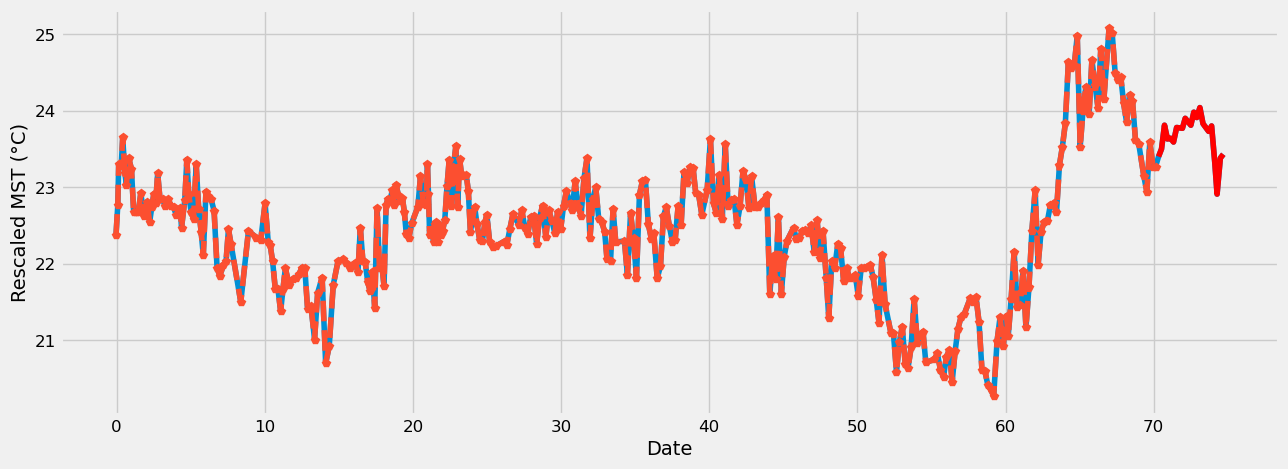

In [346]:
plt.figure(figsize=(14,5))

plt.plot(df_reverse.index, df_reverse["Rescaled MST (°C)"])

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gcf().autofmt_xdate()


plt.plot(df_reverse.index[:len(MST_train)], MST_train["Rescaled MST (°C)"], "p--",  label="Train data")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

plt.plot(df_reverse.index[-len(MST_test):], MST_test["Rescaled MST (°C)"], "r-", label="Test data")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

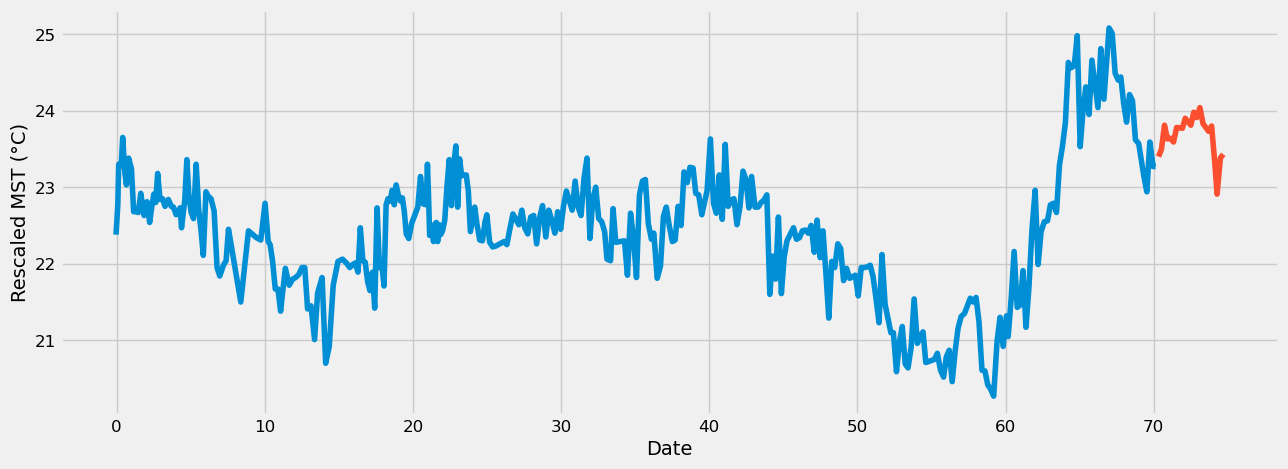

In [15]:
plt.figure(figsize=(14,5))


plt.plot(df_reverse.index[:len(MST_train)], MST_train["Rescaled MST (°C)"])

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

plt.plot(df_reverse.index[-len(MST_test):], MST_test["Rescaled MST (°C)"])

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [16]:
# lets try for Rescaled MST (°C)

beta_hat = (MST_train["Rescaled MST (°C)"].values[-1] - MST_train["Rescaled MST (°C)"].values[0])/len(MST_train)
drift_pred = MST_train["Rescaled MST (°C)"].values[-1] + beta_hat*np.arange(1,len(MST_test) + 1)
sigma = np.sqrt(((MST_train["Rescaled MST (°C)"].diff() - beta_hat)**2).sum()/len(MST_train))

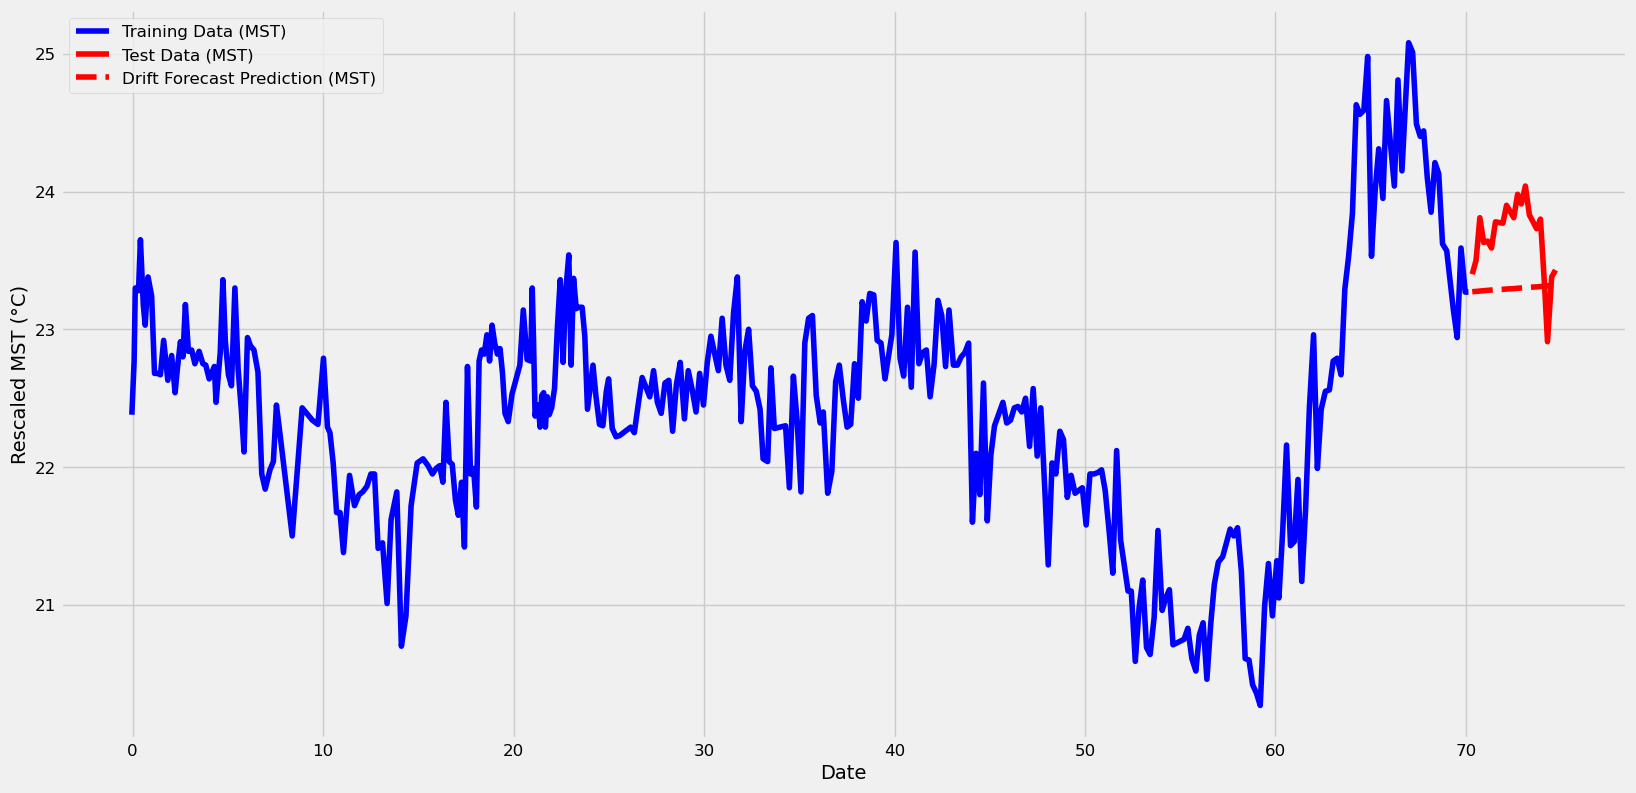

In [17]:
plt.figure(figsize=(18,9))

plt.plot(MST_train.index,
            MST_train["Rescaled MST (°C)"][-100:],
            'b-',
            label="Training Data (MST)")

plt.plot(MST_test.index,
            MST_test["Rescaled MST (°C)"],
            'r-',
            label="Test Data (MST)")

plt.plot(MST_test.index,
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (MST)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

#plt.gcf().autofmt_xdate()


plt.show()

plt.show()

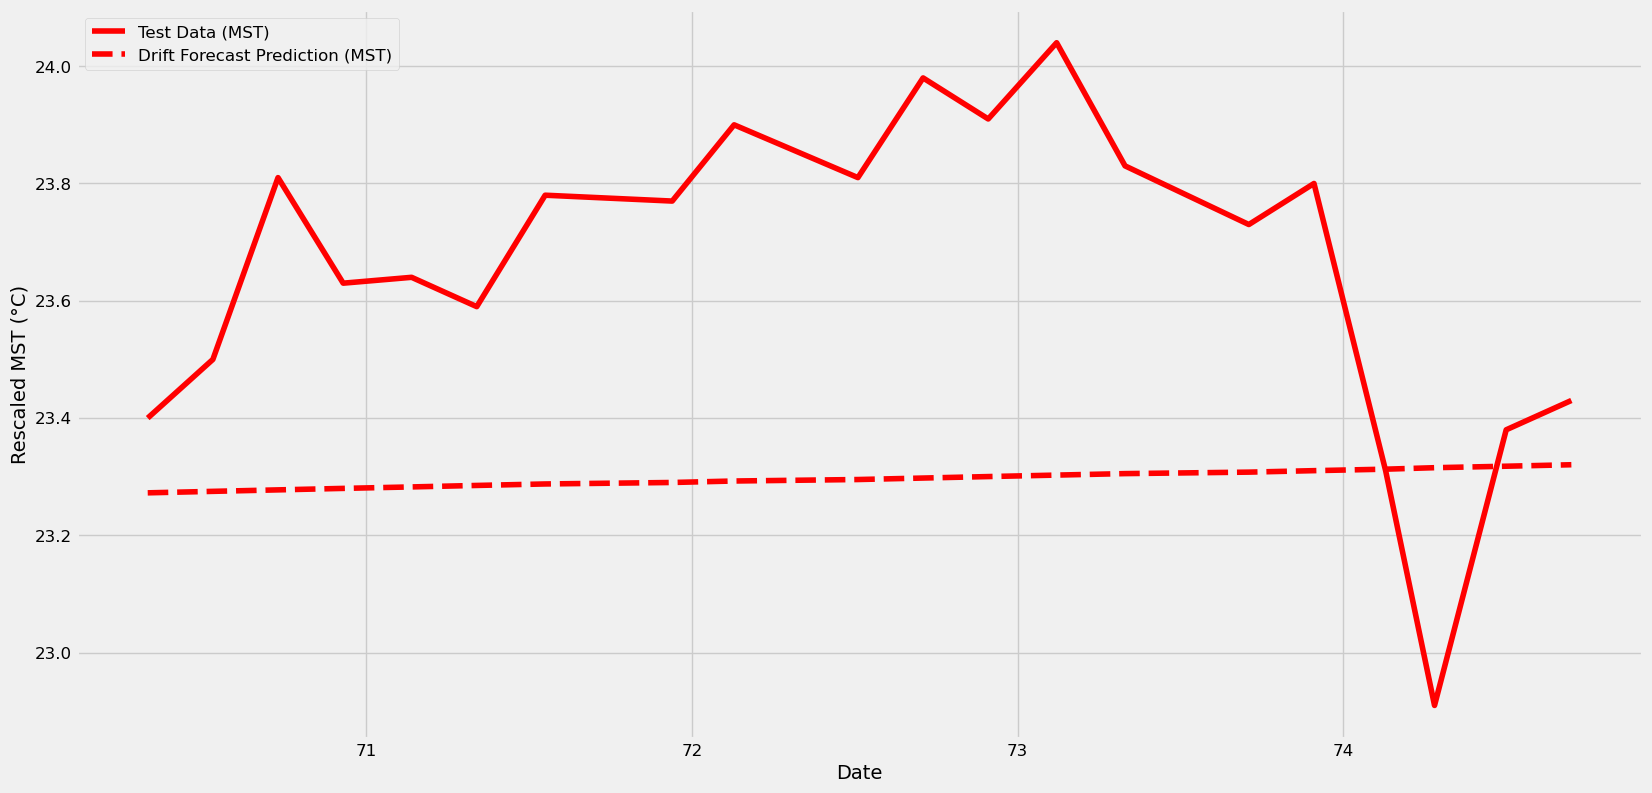

In [18]:
plt.figure(figsize=(18,9))


plt.plot(MST_test.index,
            MST_test["Rescaled MST (°C)"],
            'r-',
            label="Test Data (MST)")

plt.plot(MST_test.index,
            drift_pred,
            'r--',
            label="Drift Forecast Prediction (MST)")

plt.legend(fontsize=12, loc=2)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Rescaled MST (°C)", fontsize=14)

#plt.gcf().autofmt_xdate()


plt.show()


In [19]:
df_reverse

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index,log_RescaledMST
Age (Kyr ago),,,,,,,
-0.04,241.89,22.38,-9.20,-41.10,3.95,0.87,22.38
0.08,240.40,22.77,-9.25,-39.55,3.99,0.91,22.77
0.14,233.24,23.30,-9.33,-38.15,4.01,0.93,23.30
0.31,231.60,23.28,-9.02,-37.39,4.02,0.99,23.28
0.41,232.26,23.65,-8.71,-36.52,4.05,0.99,23.65
...,...,...,...,...,...,...,...
73.91,283.73,23.80,-9.12,-35.79,3.23,0.59,23.80
74.13,276.72,23.31,-9.52,-35.79,3.23,0.61,23.31
74.28,284.01,22.91,-9.35,-35.79,3.23,0.48,22.91


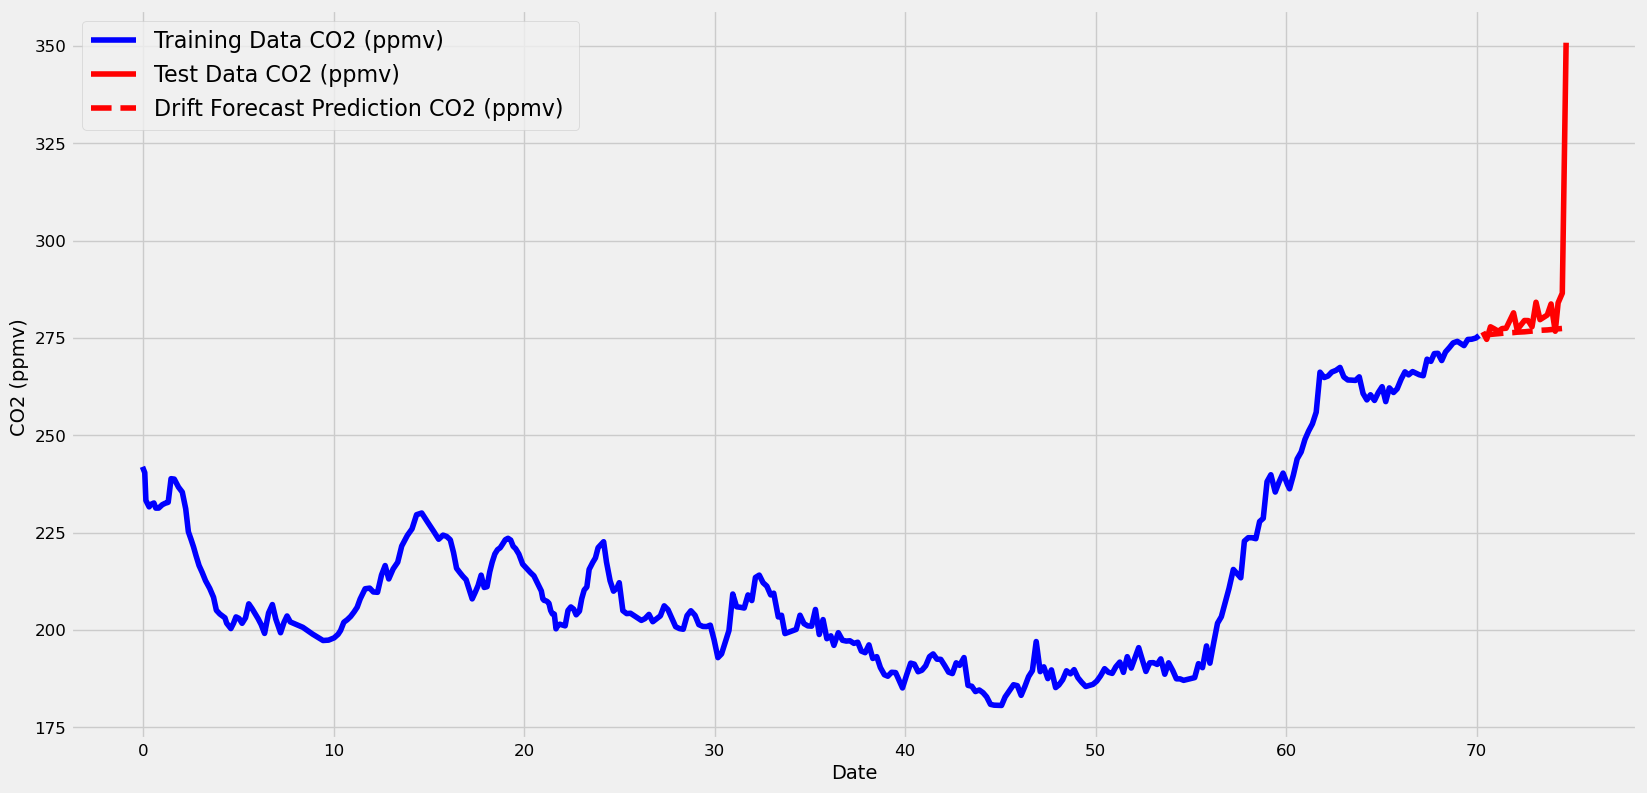

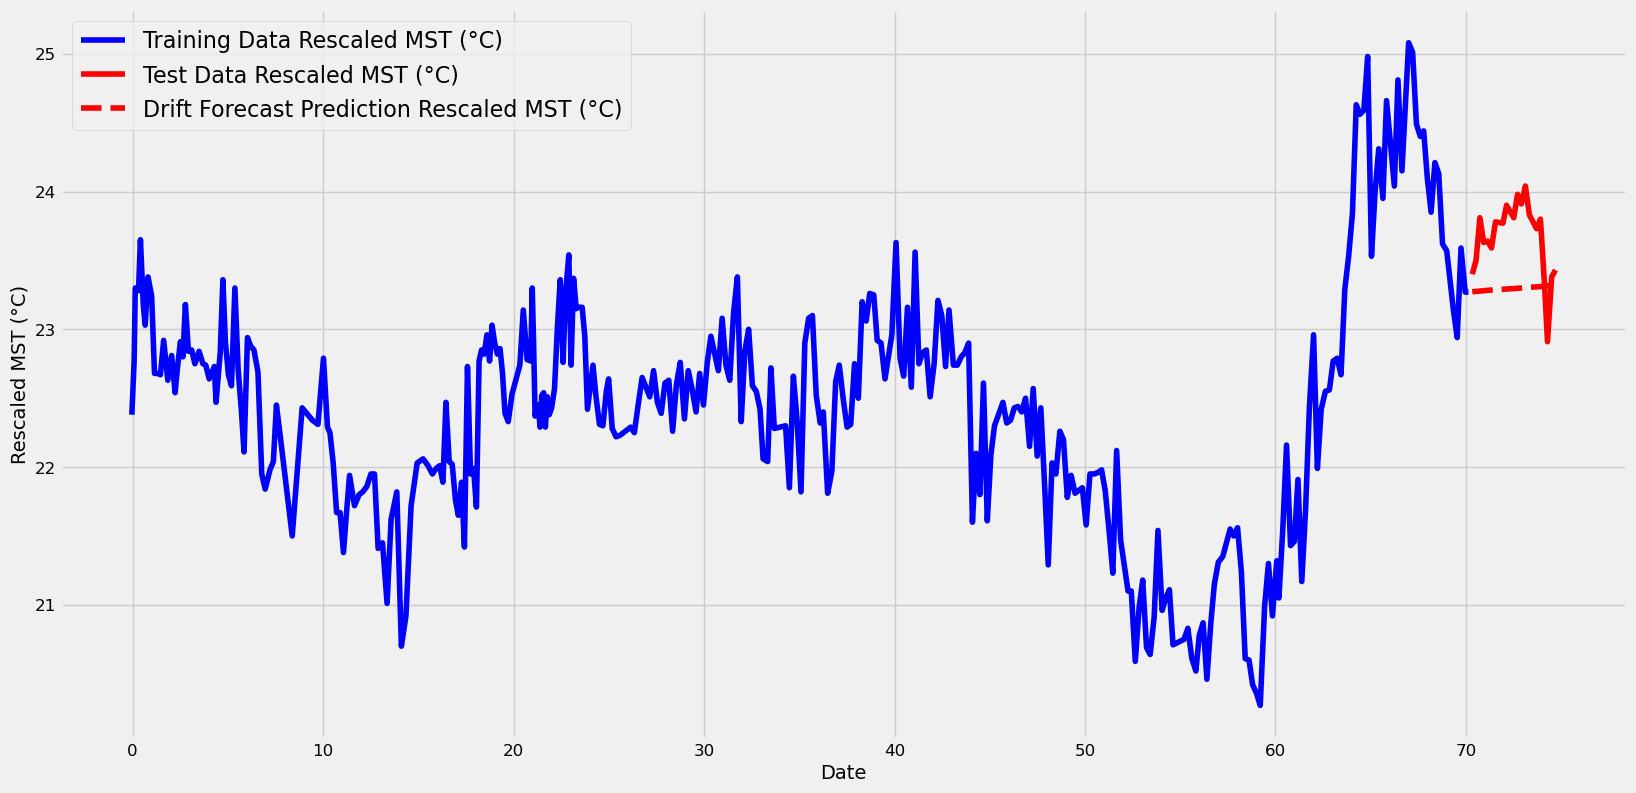

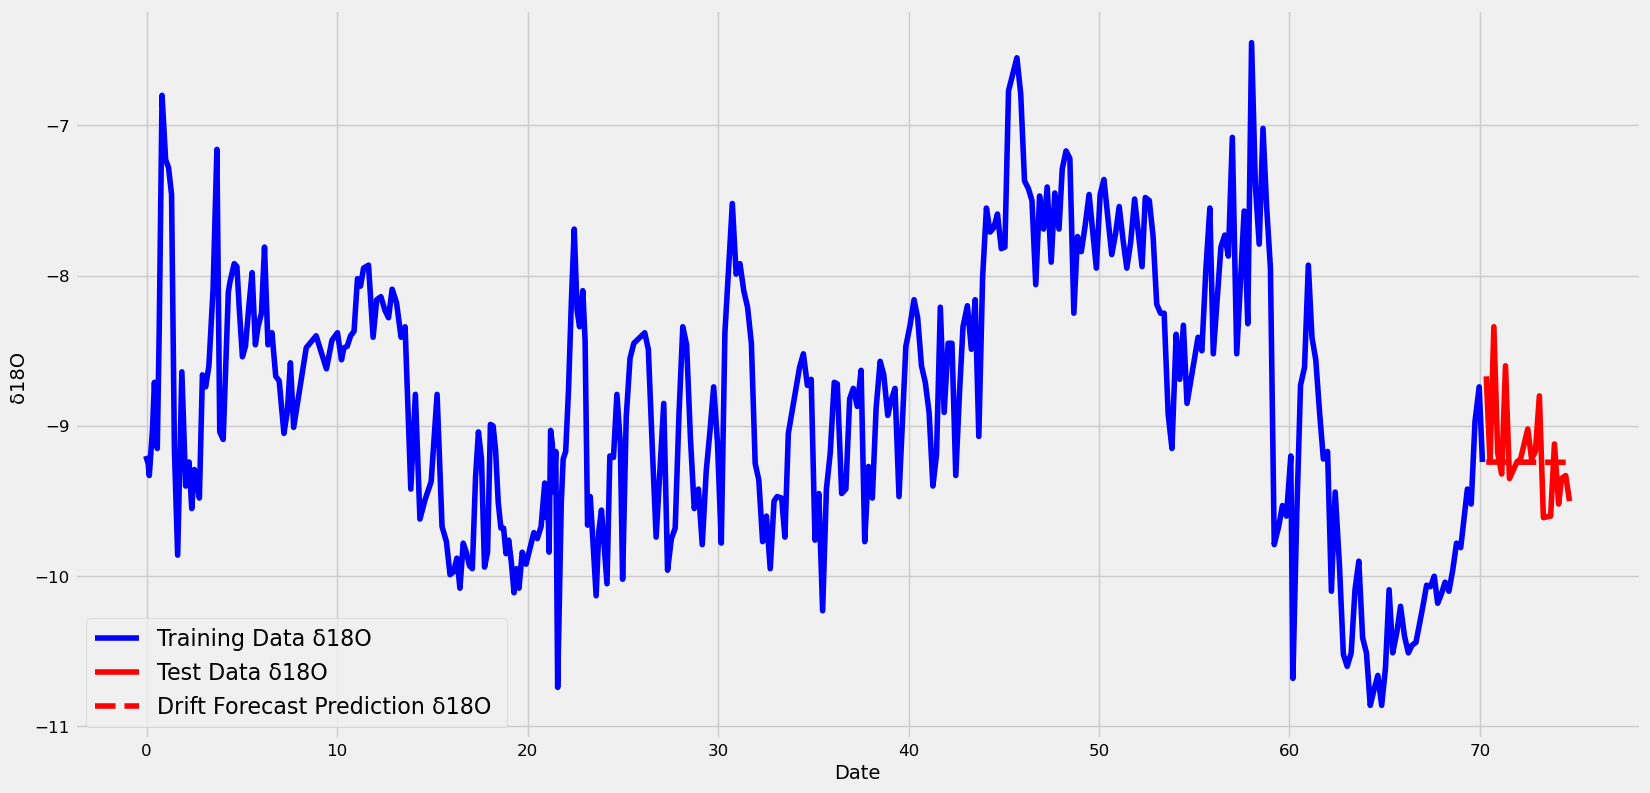

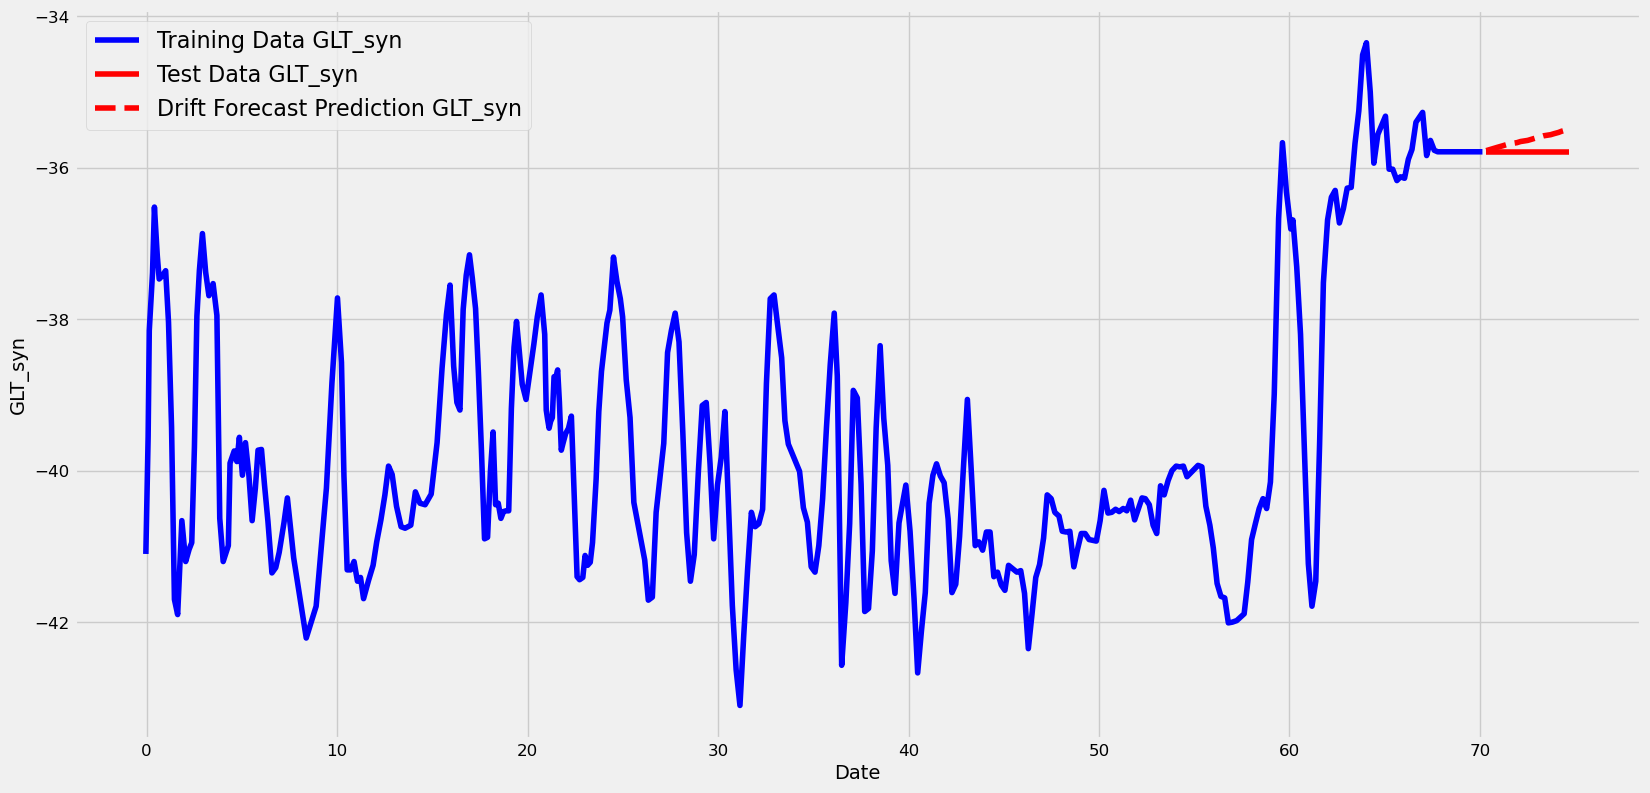

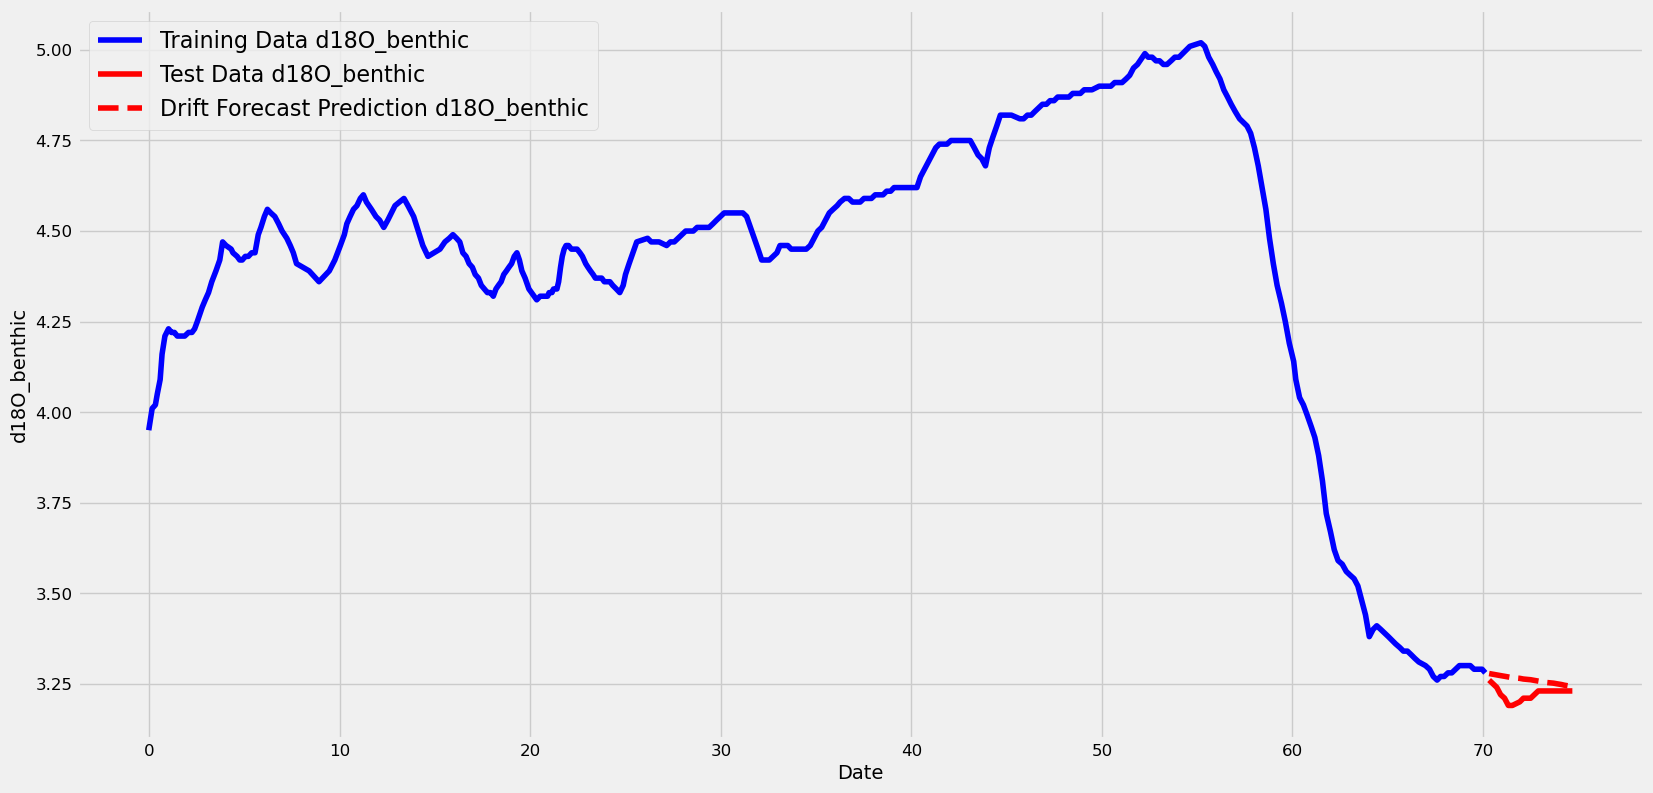

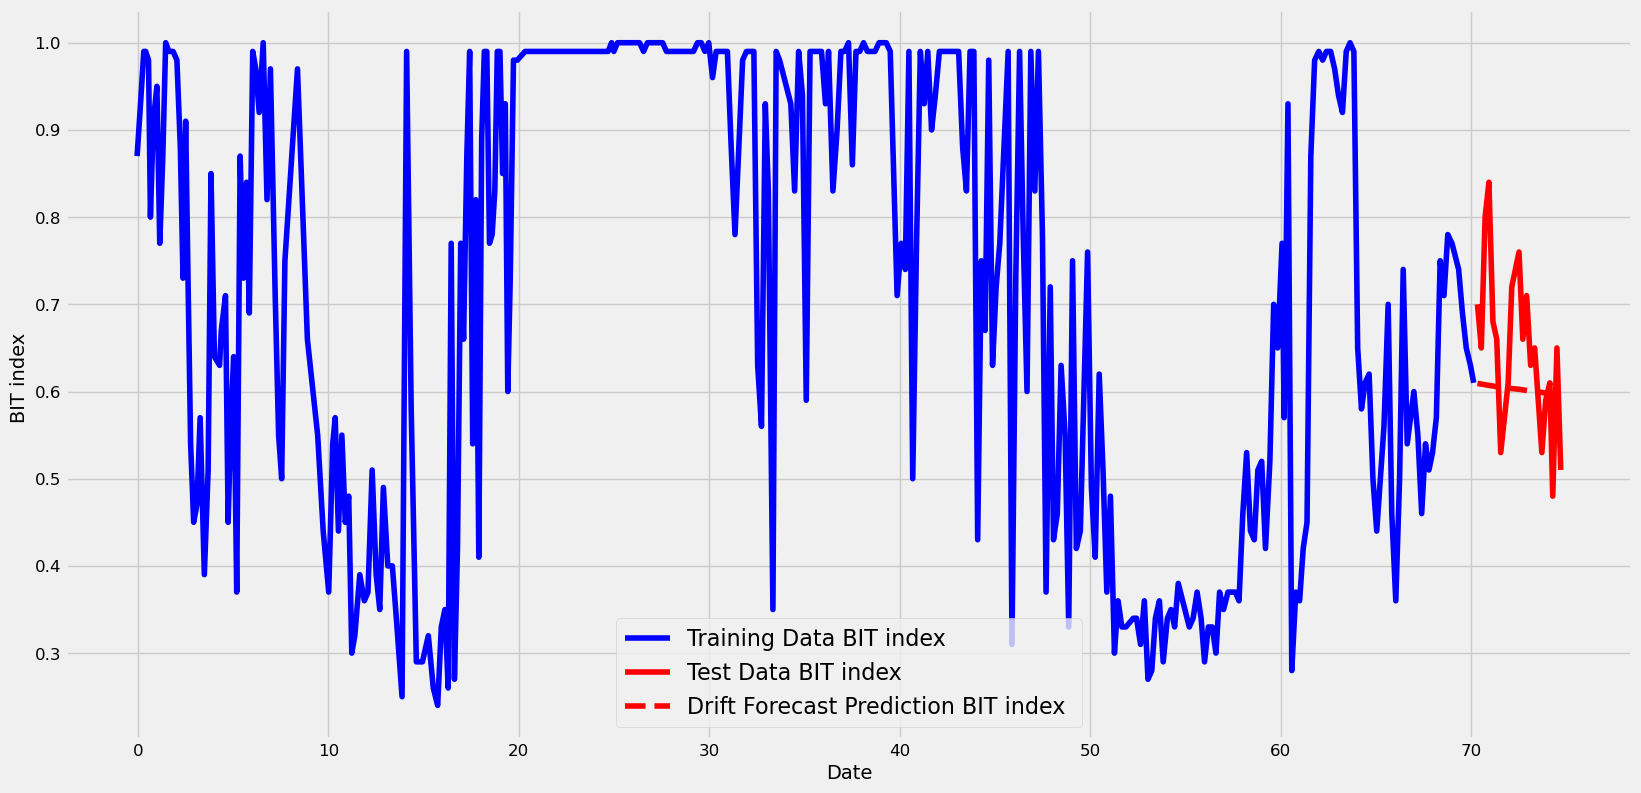

In [20]:


for col in MST_train.columns[:-1]:
    plt.figure(figsize=(18,9))
    
    # lets try for Rescaled MST (°C)

    beta_hat = (MST_train[col].values[-1] - MST_train[col].values[0])/len(MST_train)
    drift_pred = MST_train[col].values[-1] + beta_hat*np.arange(1,len(MST_test) + 1)
    sigma = np.sqrt(((MST_train[col].diff() - beta_hat)**2).sum()/len(MST_train))
    
    plt.plot(MST_train.index,
                MST_train[col],
                'b-',
                label=f"Training Data {col}")

    plt.plot(MST_test.index,
                MST_test[col],
                'r-',
                label=f"Test Data {col}")

    plt.plot(MST_test.index,
                drift_pred,
                'r--',
                label=f"Drift Forecast Prediction {col}")

    # plt.legend(fontsize=16, loc=2)
    plt.legend(fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"{col}", fontsize=14)

    #plt.gcf().autofmt_xdate()


    plt.show()


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [43]:
from statsmodels.tsa.stattools import adfuller

In [173]:
result_adf ={};
for col in df_reverse.columns[:-1]:
    result_=[];_result=[]
    for _col in adfuller(df_reverse[col]):
        if type(_col)==dict:  
            for col_ in _col.keys():
                _result.append(_col[col_])
        else:
            result_.append(_col)
    result_adf[col] = result_ + _result
    
        

In [175]:
result_adf

{'CO2 (ppmv) ': [1.7693842023528483,
  0.9982863228797266,
  5,
  367,
  2036.1261385497348,
  -3.448294490928673,
  -2.869447722240253,
  -2.570982681065269],
 'Rescaled MST (°C)': [-2.4191150954879603,
  0.1364138340329843,
  2,
  370,
  291.670429488879,
  -3.448147967010838,
  -2.8693833397824413,
  -2.5709483564645725],
 'δ18O ': [-4.458603690959344,
  0.00023342924200927872,
  1,
  371,
  465.1841605620482,
  -3.4480996560263386,
  -2.8693621113224137,
  -2.570937038891028],
 'GLT_syn': [-0.883113904787191,
  0.7934823785056805,
  15,
  357,
  571.2103402810285,
  -3.44880082033912,
  -2.869670179576637,
  -2.5711012838861036],
 'd18O_benthic': [-1.652250233208906,
  0.45586712706241905,
  14,
  358,
  -2091.653128838014,
  -3.448748905151901,
  -2.8696473721448728,
  -2.5710891239349585],
 'BIT index ': [-3.0505508795398746,
  0.030435732361181234,
  3,
  369,
  -352.0531901502907,
  -3.448196541708585,
  -2.869404683789669,
  -2.5709597356805545]}

In [182]:
result_adf = pd.DataFrame(result_adf, index=[
"ADF Statistic",
"p-value",
"Unknown",
"Unknown",
"Unknown",
"5%",
"1%",
"10%"])

In [188]:
result_adf_T = result_adf.transpose()

In [214]:
result_adf_T[result_adf_T["p-value"]<0.05]

,ADF Statistic,p-value,Unknown,Unknown,Unknown,5%,1%,10%
δ18O,-4.458604,0.000233,1.0,371.0,465.184161,-3.448100,-2.869362,-2.570937
BIT index,-3.050551,0.030436,3.0,369.0,-352.053190,-3.448197,-2.869405,-2.570960


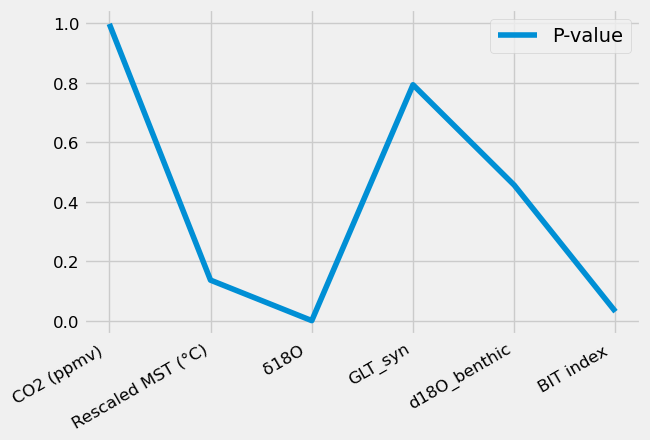

In [224]:
result_adf_T["p-value"].plot(label="P-value")
plt.legend()
plt.gcf().autofmt_xdate()

** The 'δ18O ' and 'BIT index ' are stable. Rest of the values are not stable.

###   study of stationary time series
- Define the concepts of:
    - Strict stationarity
    - Weak stationarity
- Learn about autocorrelation,
- Plot autocorrelation at different lags

In [227]:
import statsmodels.api as sm

The autocorrelation of every time series will be  1
  at lag  0
 . For stationary series, like white noise, we excpect to seem some low autocorrelation for small lags. Autocorrelation should then tend to randomly bubble around getting closer and closer to  0
  as the lag increases.

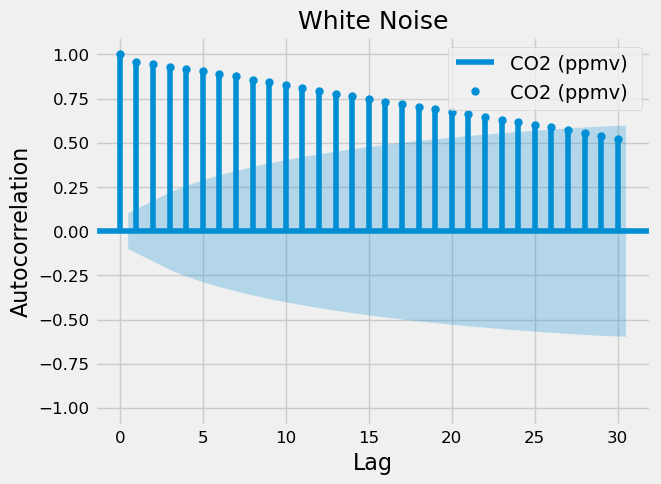

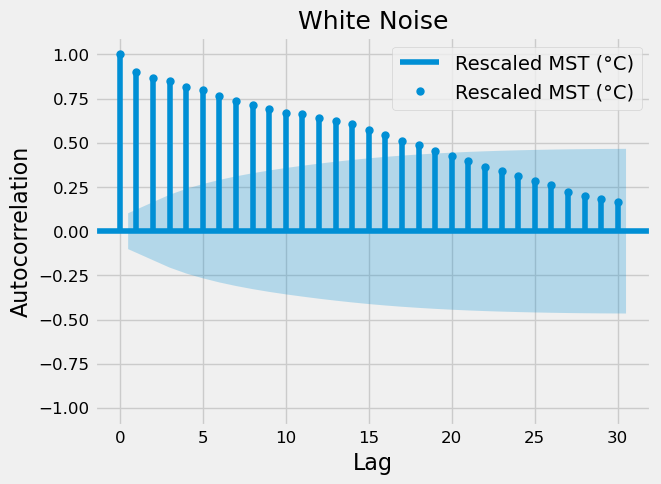

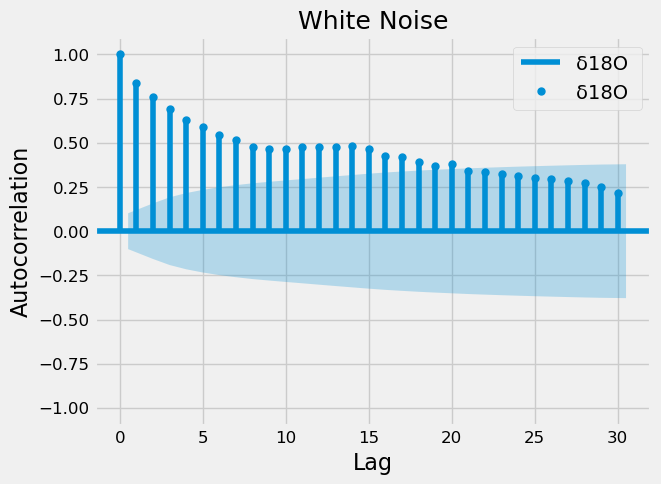

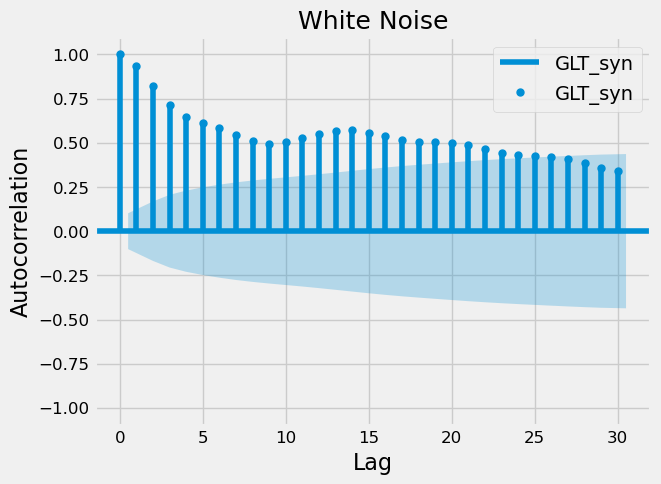

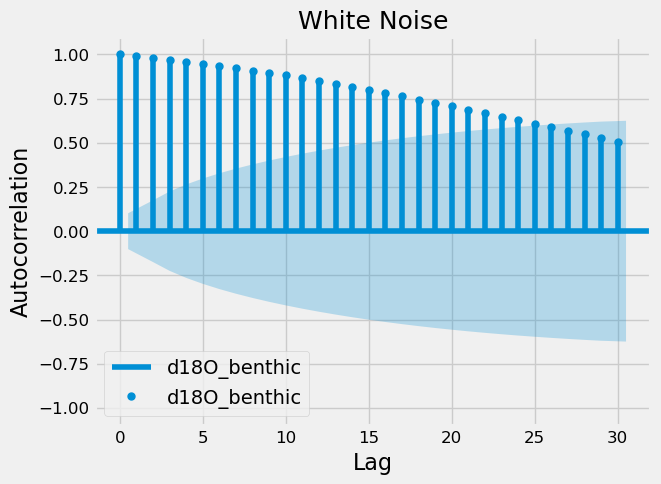

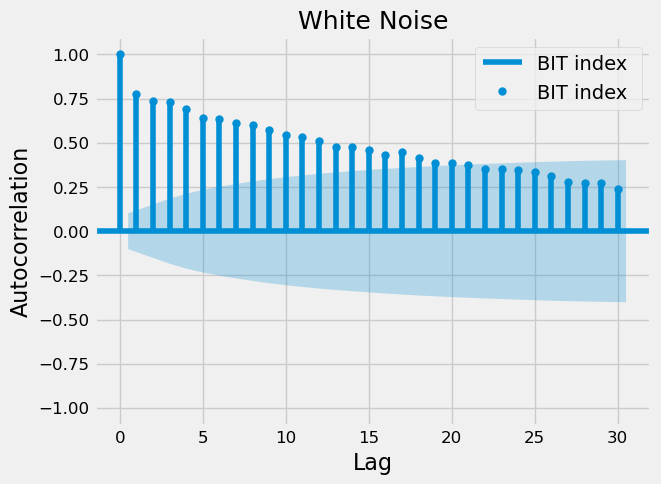

In [246]:
for col in df_reverse.columns[:-1]:
    sm.graphics.tsa.plot_acf(df_reverse[col], lags = 30, label=f"{col}")
    # sm.graphics.tsa.plot_acf(df_reverse[col], lags = 40)
    plt.title('White Noise', fontsize=18)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()

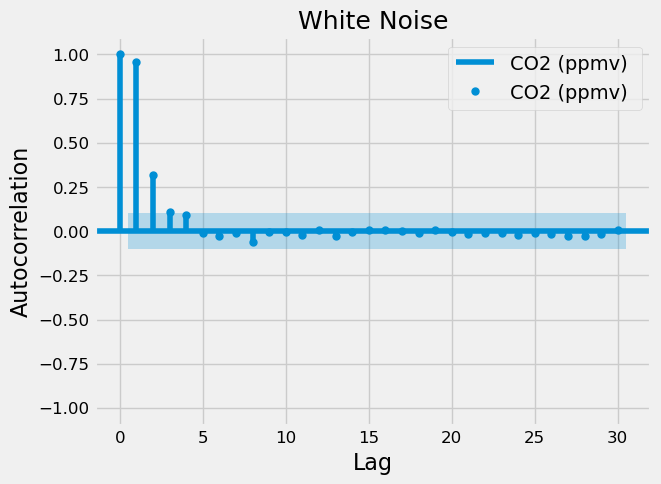

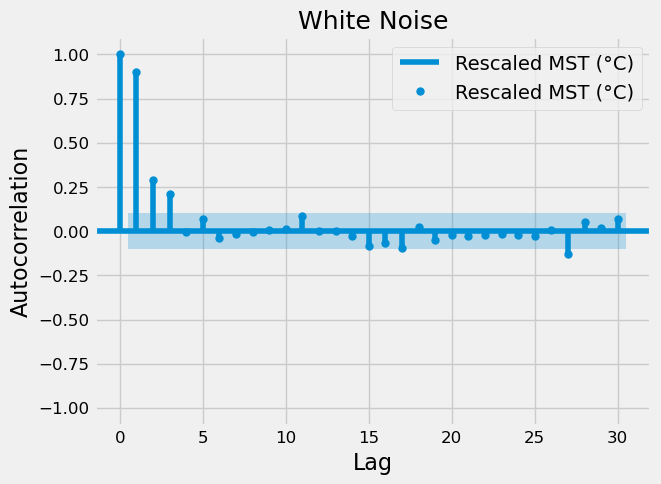

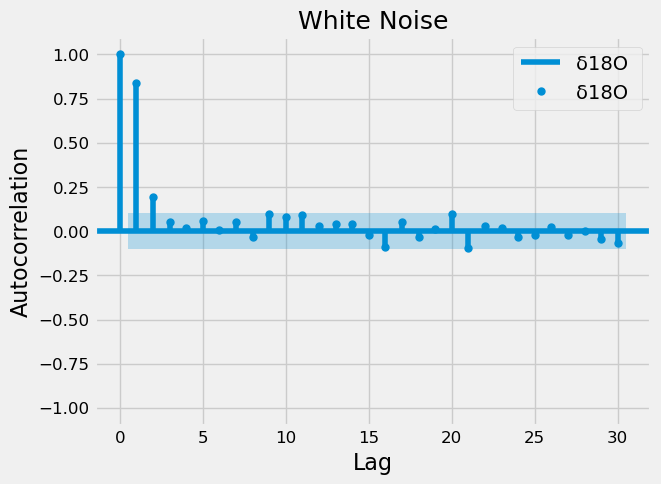

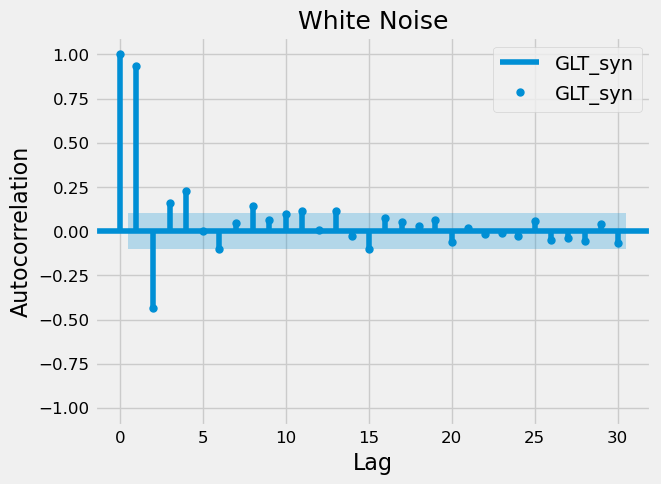

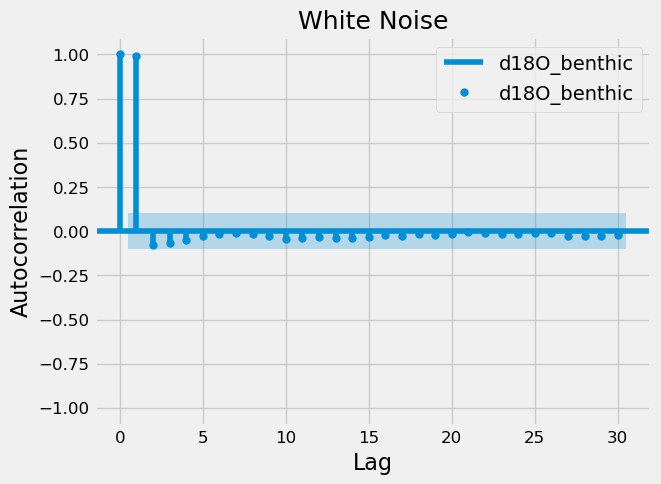

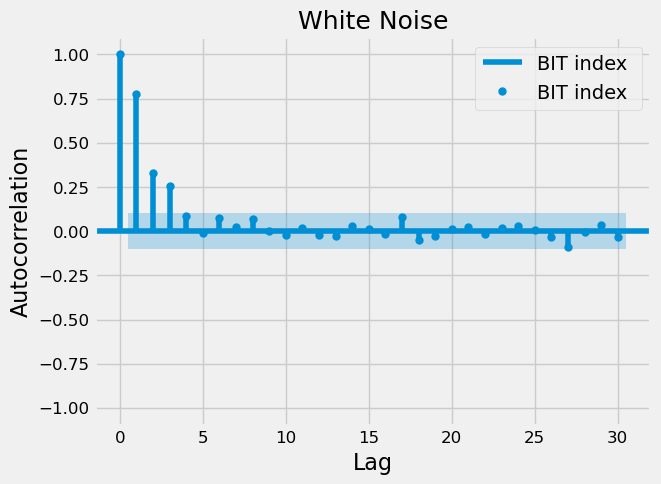

In [249]:
for col in df_reverse.columns[:-1]:
    sm.graphics.tsa.plot_pacf(df_reverse[col], lags = 30, label=f"{col}")
    # sm.graphics.tsa.plot_acf(df_reverse[col], lags = 40)
    plt.title('White Noise', fontsize=18)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()

## Differentiation

In [278]:
df_difference = df_reverse.diff().copy()

In [290]:
df_difference.fillna(value=0, inplace=True)

In [292]:
df_difference

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index,log_RescaledMST
Age (Kyr ago),,,,,,,
-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.08,-1.49,0.39,-0.05,1.55,0.04,0.04,0.39
0.14,-7.16,0.53,-0.08,1.40,0.02,0.02,0.53
0.31,-1.64,-0.02,0.31,0.76,0.01,0.06,-0.02
0.41,0.66,0.37,0.31,0.87,0.03,0.00,0.37
...,...,...,...,...,...,...,...
73.91,2.84,0.07,0.48,0.00,0.00,0.06,0.07
74.13,-7.01,-0.49,-0.40,0.00,0.00,0.02,-0.49
74.28,7.29,-0.40,0.17,0.00,0.00,-0.13,-0.40


In [294]:
result_adf ={};
for col in df_difference.columns[:-1]:
    result_=[];_result=[]
    for _col in adfuller(df_difference[col]):
        if type(_col)==dict:  
            for col_ in _col.keys():
                _result.append(_col[col_])
        else:
            result_.append(_col)
    result_adf[col] = result_ + _result

In [296]:
result_adf = pd.DataFrame(result_adf, index=[
"ADF Statistic",
"p-value",
"Unknown",
"Unknown",
"Unknown",
"5%",
"1%",
"10%"])

In [298]:
result_adf_T = result_adf.transpose()

In [300]:
result_adf_T[result_adf_T["p-value"]<0.05]

,ADF Statistic,p-value,Unknown,Unknown,Unknown,5%,1%,10%
CO2 (ppmv),-3.276095,1.598142e-02,4.0,368.0,2037.616688,-3.448245,-2.869426,-2.570971
Rescaled MST (°C),-19.721460,0.000000e+00,1.0,371.0,295.041032,-3.448100,-2.869362,-2.570937
δ18O,-9.324185,9.710134e-16,9.0,363.0,473.373014,-3.448494,-2.869535,-2.571029
GLT_syn,-7.357495,9.693743e-11,14.0,358.0,570.048055,-3.448749,-2.869647,-2.571089
d18O_benthic,-4.666273,9.732540e-05,6.0,366.0,-2092.240462,-3.448344,-2.869469,-2.570994
BIT index,-16.204960,4.041155e-29,2.0,370.0,-345.265842,-3.448148,-2.869383,-2.570948


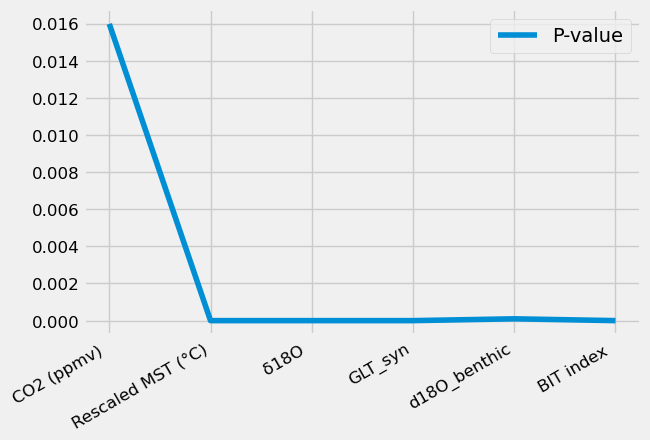

In [302]:
result_adf_T["p-value"].plot(label="P-value")
plt.legend()
plt.gcf().autofmt_xdate()

The differencings are stationary!!!!!! 
Lets go chack ACF and PACF.

In [306]:
df_difference.columns

Index(['CO2 (ppmv) ', 'Rescaled MST (°C)', 'δ18O ', 'GLT_syn', 'd18O_benthic',
       'BIT index ', 'log_RescaledMST'],
      dtype='object')

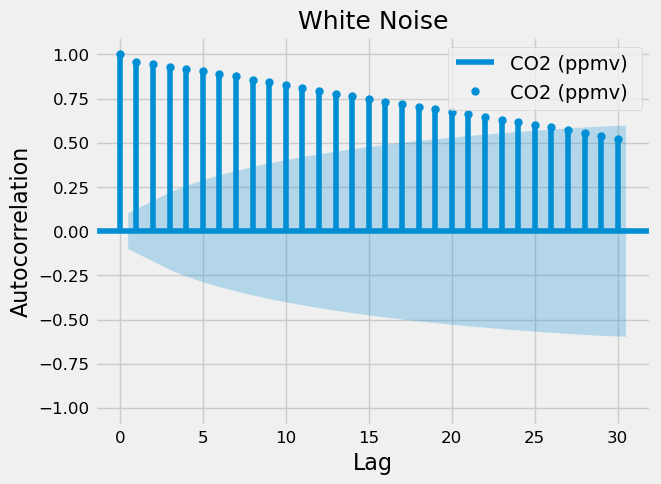

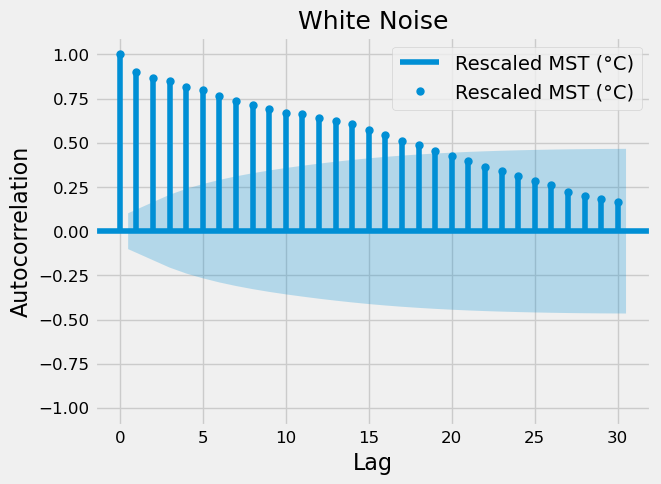

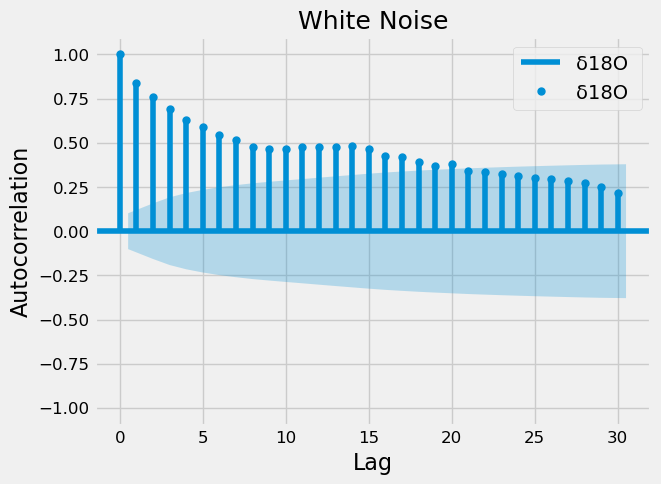

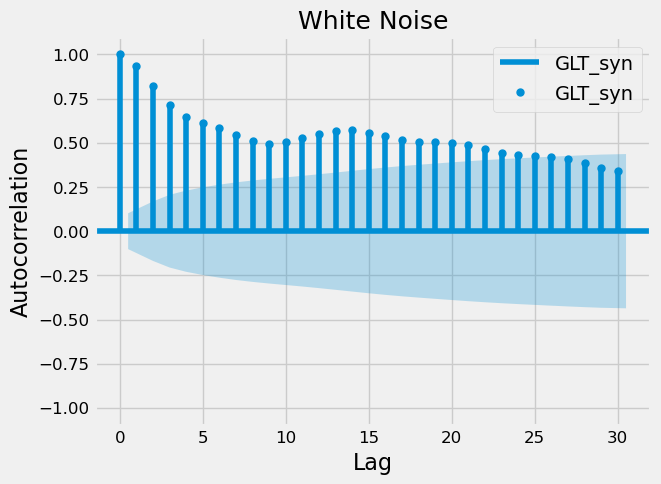

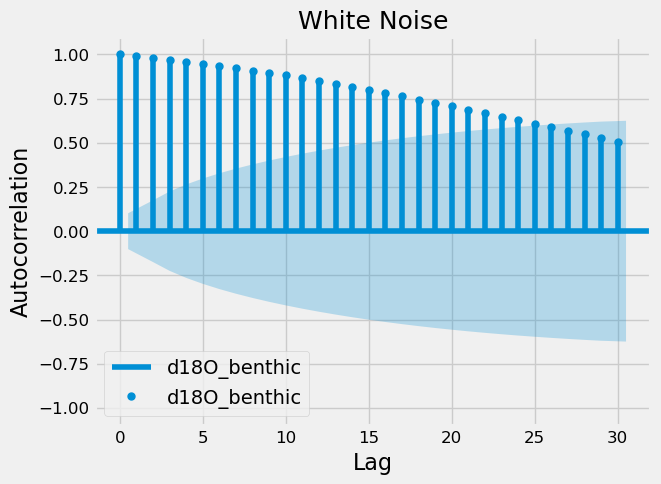

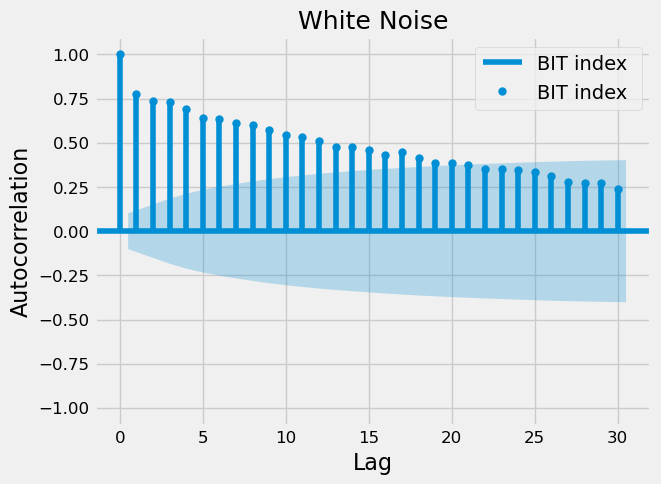

In [308]:
for col in df_difference.columns[:-1]:
    sm.graphics.tsa.plot_acf(df_reverse[col], lags = 30, label=f"{col}")
    # sm.graphics.tsa.plot_acf(df_reverse[col], lags = 40)
    plt.title('White Noise', fontsize=18)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()

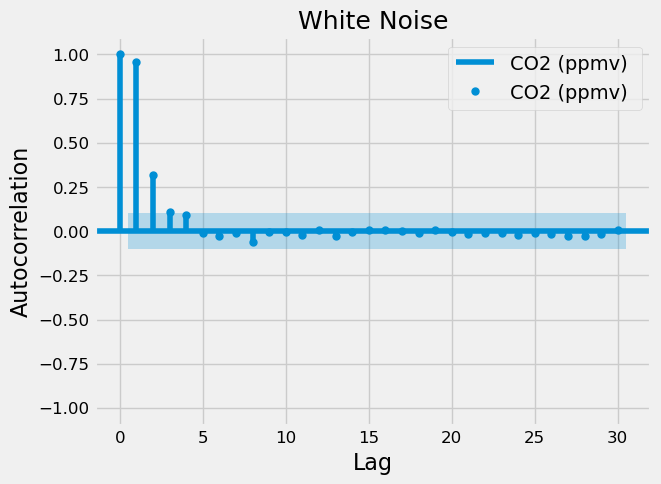

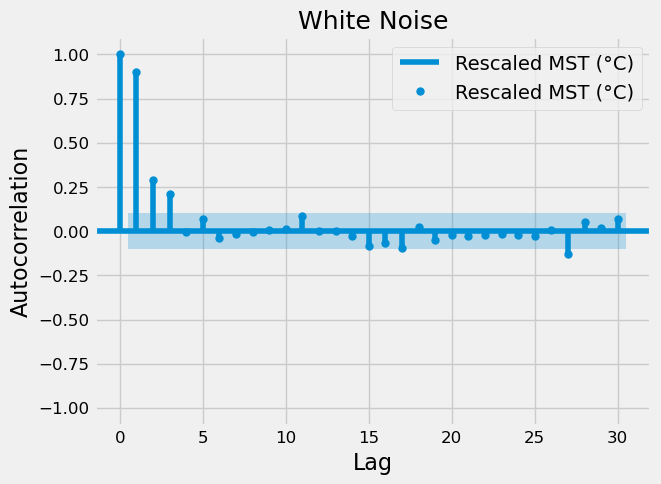

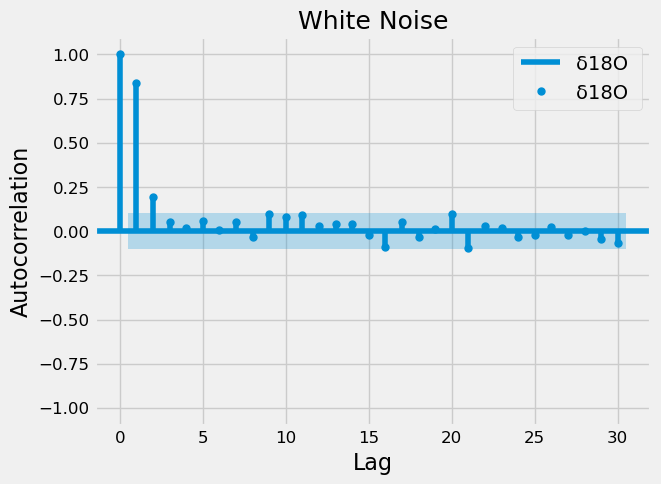

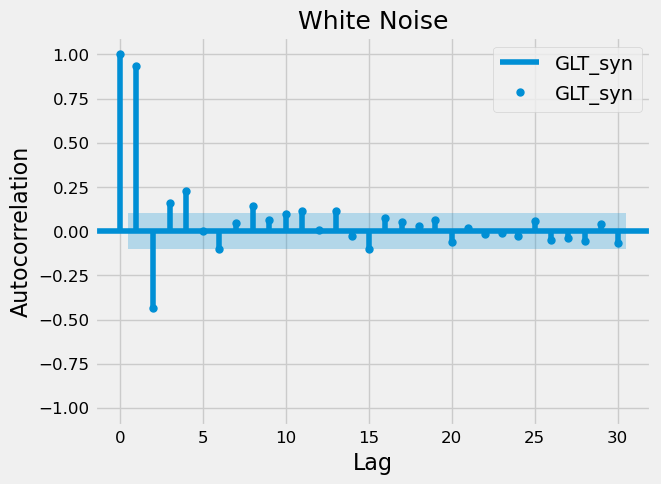

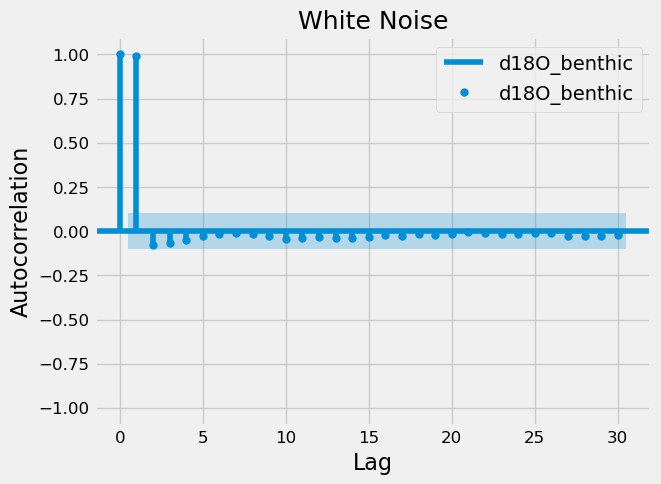

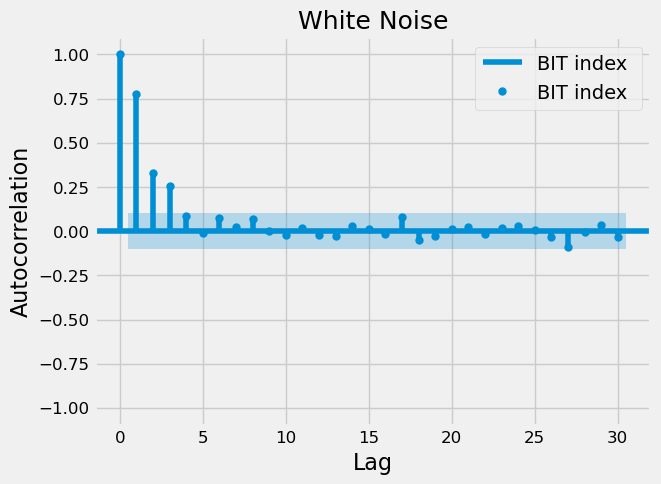

In [310]:
for col in df_difference.columns[:-1]:
    sm.graphics.tsa.plot_pacf(df_reverse[col], lags = 30, label=f"{col}")
    # sm.graphics.tsa.plot_acf(df_reverse[col], lags = 40)
    plt.title('White Noise', fontsize=18)
    plt.ylabel("Autocorrelation", fontsize=16)
    plt.xlabel("Lag", fontsize=16)

    plt.ylim(-1.1,1.1)
    plt.legend()
    plt.show()

## RMSE

In [348]:
from pmdarima import auto_arima

In [352]:
MST_train.head()

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index
Age (Kyr ago),,,,,,
-0.04,241.89,22.38,-9.20,-41.10,3.95,0.87
0.08,240.40,22.77,-9.25,-39.55,3.99,0.91
0.14,233.24,23.30,-9.33,-38.15,4.01,0.93
0.31,231.60,23.28,-9.02,-37.39,4.02,0.99
0.41,232.26,23.65,-8.71,-36.52,4.05,0.99


In [358]:
model = auto_arima(MST_train["BIT index "], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-338.084, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-243.102, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-303.000, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-342.148, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-245.095, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-340.820, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-340.936, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-339.565, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-344.090, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-342.756, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-342.871, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-304.984, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-341.502, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.159 seconds


In [370]:
model = auto_arima(MST_train["BIT index "], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(MST_train["BIT index "])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-338.084, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-243.102, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-303.000, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-342.148, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-245.095, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-340.820, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-340.936, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-339.565, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-344.090, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-342.756, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-342.871, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-304.984, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-341.502, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.104 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [420]:
 forecast = model.predict(n_periods=len(MST_test["BIT index "]))

C:\Users\rd\.conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [424]:
type(forecast)

pandas.core.series.Series

In [426]:
MST_test["BIT index "].index

Index([70.33, 70.53, 70.73, 70.93, 71.14, 71.34, 71.55, 71.94, 72.13, 72.51,
       72.71, 72.91, 73.12, 73.33, 73.71, 73.91, 74.13, 74.28,  74.5,  74.7],
      dtype='float64', name='Age (Kyr ago)')

In [432]:
forecast = pd.DataFrame(forecast, columns=['Prediction'])

In [440]:
forecast.index = MST_test["BIT index "].index.copy()

In [442]:
forecast

,Prediction
Age (Kyr ago),
70.33,0.644005
70.53,0.644005
70.73,0.644005
70.93,0.644005
71.14,0.644005
71.34,0.644005
71.55,0.644005
71.94,0.644005
72.13,0.644005


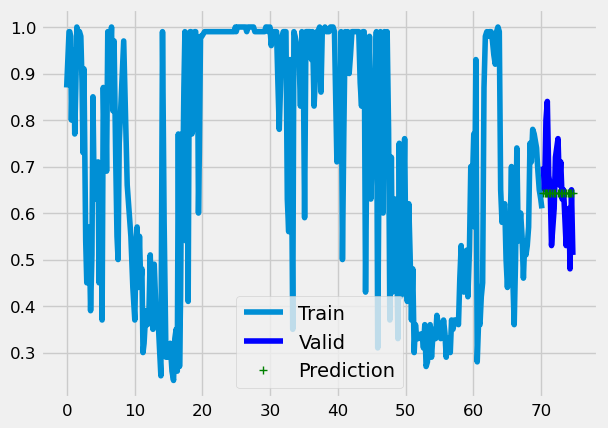

In [444]:
# forecast = model.predict(n_periods=len(MST_test["BIT index"]))


#plot the predictions for validation set
plt.plot(MST_train["BIT index "], label='Train')
plt.plot(MST_test["BIT index "], "b-", label='Valid')
plt.plot(forecast, "g+", label='Prediction')
plt.legend()
plt.show()

In [489]:
train_diff = df_difference.iloc[:-20].copy()
test_diff = df_difference.iloc[-20:].copy()

In [484]:
train_diff

,CO2 (ppmv),Rescaled MST (°C),δ18O,GLT_syn,d18O_benthic,BIT index,log_RescaledMST
Age (Kyr ago),,,,,,,
-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.08,-1.49,0.39,-0.05,1.55,0.04,0.04,0.39
0.14,-7.16,0.53,-0.08,1.40,0.02,0.02,0.53
0.31,-1.64,-0.02,0.31,0.76,0.01,0.06,-0.02
0.41,0.66,0.37,0.31,0.87,0.03,0.00,0.37
...,...,...,...,...,...,...,...
69.34,-1.09,-0.43,0.39,0.00,0.00,-0.03,-0.43
69.54,1.58,-0.20,-0.10,0.00,-0.01,-0.05,-0.20
69.74,0.06,0.65,0.55,0.00,0.00,-0.04,0.65


In [495]:
model = auto_arima(train_diff["BIT index "], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(test_diff["BIT index "])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-340.007, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-244.805, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-304.868, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-344.067, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-246.799, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-342.745, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-342.862, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-341.493, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-346.015, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-344.688, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-344.804, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-306.853, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-343.436, Time=0.11 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.212 seconds


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

(0,0,1)(0,0,0) d = 0 

In [503]:
forecast = model.predict(n_periods=len(test_diff["BIT index "]))

C:\Users\rd\.conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [505]:
forecast = pd.DataFrame(forecast, columns=['Prediction'])

In [507]:
forecast.index = MST_test["BIT index "].index.copy()

In [511]:
forecast

,Prediction
Age (Kyr ago),
70.33,0.055052
70.53,0.000000
70.73,0.000000
70.93,0.000000
71.14,0.000000
71.34,0.000000
71.55,0.000000
71.94,0.000000
72.13,0.000000


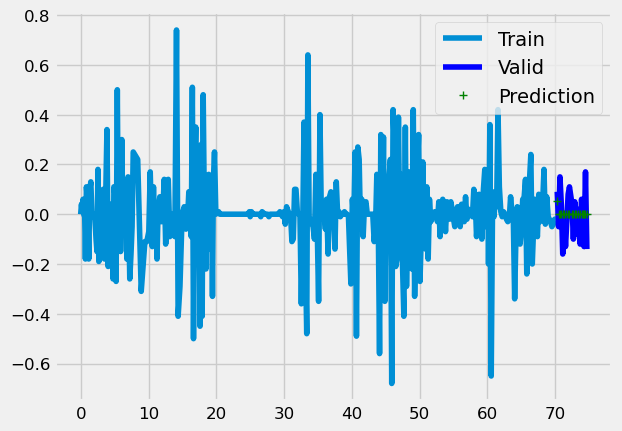

In [509]:
plt.plot(train_diff["BIT index "], label='Train')
plt.plot(test_diff["BIT index "], "b-", label='Valid')
plt.plot(forecast, "g+", label='Prediction')
plt.legend()
plt.show()